In [1]:
# -*- coding: utf-8 -*-

In [2]:
import re
import os
import sys
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
from scipy import stats
import csv
import pprint
from collections import defaultdict
import time
import datetime
import math
# import matplotlib.pyplot as plt; plt.rcdefaults()
# from IPython.display import Markdown, display

In [3]:
TIME_CHUNK_IN_DAYS = 10
QUARANTINE_DATES = {
    "theredpill": "28/09/2018",
    "the_donald": "26/06/2019",
    "fullcommunism": "27/09/2018"
}

In [4]:
SUBREDDIT = "fullcommunism"

In [5]:
QUARANTINE_DATE = QUARANTINE_DATES[SUBREDDIT]
quarDataUnix = time.mktime(datetime.datetime.strptime(QUARANTINE_DATE, "%d/%m/%Y").timetuple())

def getTimeChunkIndex(timeStamp):
    timeStamp = float(timeStamp)
    timeDiff = timeStamp - quarDataUnix
    timeDiffDays = float(timeDiff)/(24*60*60) 
    chunkIndex = math.floor(timeDiffDays/TIME_CHUNK_IN_DAYS)
    return int(chunkIndex)

###load files and preprocess dataframes
ALL_COMMENTS_FILE = "/mnt/storage/quarantine/new_data/%s/comments.csv" % (SUBREDDIT,)
ALL_SUBMISSIONS_FILE = "/mnt/storage/quarantine/new_data/%s/submissions.csv" % (SUBREDDIT,)

# PRE_QUARANTINE_USERS_FILE = "/mnt/storage/quarantine/data/preQuarantineUsers.csv"
# TOXICITY_COMMENTS_FILE = "/mnt/storage/quarantine/data/TheRedPill-comments-toxicity.csv"
# TOXICITY_SUBMISSIONS_FILE = "/mnt/storage/quarantine/data/TheRedPill-submissions-toxicity.csv"

comments_data = pd.read_csv(ALL_COMMENTS_FILE)
submissions_data = pd.read_csv(ALL_SUBMISSIONS_FILE)
# toxicity_comments_data = pd.read_csv(TOXICITY_COMMENTS_FILE)
# toxicity_submissions_data = pd.read_csv(TOXICITY_SUBMISSIONS_FILE)

data = pd.concat([comments_data, submissions_data], ignore_index=True)
data['title'] = data['title'].fillna("EMPTY")
data['body'] = data['body'].fillna("EMPTY")

comments_data.shape[0] + submissions_data.shape[0], data.shape[0]

# data = pd.read_csv("/mnt/storage/quarantine/data/theRedPillComments-toxicity.csv")
data['post_treatment'] = data['created_utc'] > quarDataUnix
data['time'] = data['created_utc'].apply(getTimeChunkIndex)
# data = data[data.toxicity != -1]

/nethome/sjhaver3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# 1) ITS analysis for posting volume within r/TRP

In [7]:
TrpRemovalCount = {}
TotalNumberComments = {}

for i, row in data.iterrows():
        body = row['body']
        selftext = row['selftext']
        postTime = row['created_utc']
        timeChunkIndex = getTimeChunkIndex(postTime)
        
        if timeChunkIndex in TotalNumberComments:
            TotalNumberComments[timeChunkIndex] += 1
        else:
            TotalNumberComments[timeChunkIndex] = 1
        
        ###count #removed
        if ((body == "[removed]") | (selftext == "[removed]")):
            if timeChunkIndex in TrpRemovalCount:
                TrpRemovalCount[timeChunkIndex] += 1
            else:
                TrpRemovalCount[timeChunkIndex] = 1

##get the removal rate: i.e., #removed comments normalized by #total comments
TrpRemovalRate = {}
for k in TrpRemovalCount:
    if TotalNumberComments[k] == 0:
        TrpRemovalRate[k] = 0
    else:      
        TrpRemovalRate[k] = float(TrpRemovalCount[k])/(TotalNumberComments[k])

Optimization terminated successfully.
         Current function value: 152.651629
         Iterations 5
                           Results: Poisson
Model:                 Poisson            Pseudo R-squared:   0.306    
Dependent Variable:    counts             AIC:                7027.9749
Date:                  2020-03-26 22:43   BIC:                7031.3814
No. Observations:      23                 Log-Likelihood:     -3511.0  
Df Model:              2                  LL-Null:            -5061.4  
Df Residuals:          20                 LLR p-value:        0.0000   
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        5.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               7.4315   0.0137 543.3059 0.0000  7.4

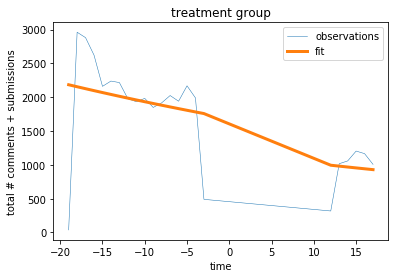

In [8]:
# posting volume
TotalNumberComments_df = pd.DataFrame()
TotalNumberComments_df['time'] = TotalNumberComments.keys()
TotalNumberComments_df['counts'] = TotalNumberComments.values()
TotalNumberComments_df['post_treatment'] = TotalNumberComments_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TotalNumberComments_df)
results = model.fit()

print(results.summary2())

# fitted values
TotalNumberComments_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TotalNumberComments_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TotalNumberComments_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('total # comments + submissions');

In [9]:
coeff = results.params[1]
"Coeff = ", coeff, "Effect = ", np.sign(coeff) * (100* (1.0 - np.exp(coeff)))

('Coeff = ', -0.366510005359949, 'Effect = ', -30.685079875939657)

# Result 1: There was a significant reduction in posting volume (comments + submissions) within r/TRP that was caused by the quarantine.

## % decrease = 52.37%

# 2) ITS analysis for the influx of new users (i.e., rate of newcomers)

In [10]:
authorsInEachChunk = defaultdict(set)

with open(ALL_COMMENTS_FILE) as csvfile:
    readCSV = csv.DictReader(csvfile)
    for row in readCSV:
        author = row['author']
        if (author != "[deleted]"):
            postTime = row['created_utc']
            timeChunkIndex = getTimeChunkIndex(postTime)
            authorsInEachChunk[timeChunkIndex].add(author) 

with open(ALL_SUBMISSIONS_FILE) as csvfile:
    readCSV = csv.DictReader(csvfile)
    for row in readCSV:
        author = row['author']
        if (author != "[deleted]"):
            postTime = row['created_utc']
            timeChunkIndex = getTimeChunkIndex(postTime)
            authorsInEachChunk[timeChunkIndex].add(author) 
            
lists = sorted(authorsInEachChunk.items())

seenUsersSet = set()
for ulist in lists[0:3]:
    chunkUsers = ulist[1]
    seenUsersSet = seenUsersSet.union(chunkUsers)
    
newsUsersCount = defaultdict(int)
for ulist in lists[4:]:
    chunkIndex = ulist[0]
    chunkUsers = ulist[1]
    newUsersSet = chunkUsers.difference(seenUsersSet)
    newsUsersCount[chunkIndex] = len(newUsersSet)
    seenUsersSet = seenUsersSet.union(chunkUsers)

Optimization terminated successfully.
         Current function value: 8.041809
         Iterations 6
                           Results: Poisson
Model:                 Poisson           Pseudo R-squared:  0.747      
Dependent Variable:    counts            AIC:               311.5888   
Date:                  2020-03-26 22:46  BIC:               314.4221   
No. Observations:      19                Log-Likelihood:    -152.79    
Df Model:              2                 LL-Null:           -603.07    
Df Residuals:          16                LLR p-value:       2.8031e-196
Converged:             1.0000            Scale:             1.0000     
No. Iterations:        6.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               4.9455   0.0473 104.6672 0.0000  4.852

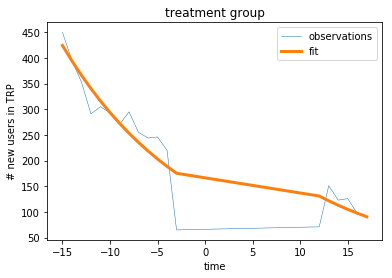

In [11]:
# # comments removed
TrpNewUsersCount_df = pd.DataFrame()
TrpNewUsersCount_df['time'] = newsUsersCount.keys()
TrpNewUsersCount_df['counts'] = newsUsersCount.values()
TrpNewUsersCount_df['post_treatment'] = TrpNewUsersCount_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TrpNewUsersCount_df)
results = model.fit()

print(results.summary2())
# fitted values
TrpNewUsersCount_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpNewUsersCount_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpNewUsersCount_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('# new users in TRP');

In [12]:
coeff = results.params[1]
"Coeff = ", coeff, "Effect = ", np.sign(coeff) * (100* (1.0 - np.exp(coeff)))

('Coeff = ', 0.813738834323549, 'Effect = ', -125.63282734329597)

# Result 2: There was a significant reduction in newcomer rates within r/TRP that was caused by the quarantine.

## % decrease = 52.88%

# 3) ITS analysis for rate of comment removals within r/TRP

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.438     
Dependent Variable:  counts            AIC:                 -122.7933 
Date:                2020-03-26 22:47  BIC:                 -119.3869 
No. Observations:    23                Log-Likelihood:      64.397    
Df Model:            2                 F-statistic:         9.568     
Df Residuals:        20                Prob (F-statistic):  0.00122   
R-squared:           0.489             Scale:               0.00024906
----------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------
Intercept               0.1114   0.0092 12.0545 0.0000  0.0922  0.1307
post_treatment[T.True] -0.0885   0.0209 -4.2353 0.0004 -0.1321 -0.0449
time                    0.0027   0.0008  3.5612 0.0020  0.0011  0.0043
--------------------------

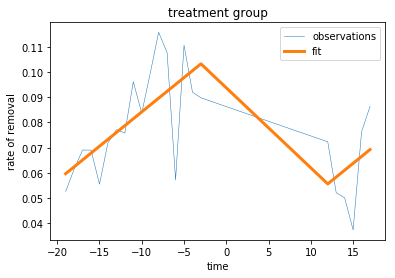

In [13]:
# # comments removed
TrpRemovalRate_df = pd.DataFrame()
TrpRemovalRate_df['time'] = TrpRemovalRate.keys()
TrpRemovalRate_df['counts'] = TrpRemovalRate.values()
TrpRemovalRate_df['post_treatment'] = TrpRemovalRate_df['time'] >= 0

# ITS
model = smf.ols('counts ~ time + post_treatment',data = TrpRemovalRate_df)
results = model.fit()

print(results.summary2())

# fitted values
TrpRemovalRate_df['fit'] = (results.fittedvalues)
# TrpRemovalRate_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpRemovalRate_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpRemovalRate_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('rate of removal');

In [14]:
coeff = results.params[1]
"Coefficient = ", coeff,"Effect = ", np.ceil(100* coeff), "%"

('Coefficient = ', -0.08851395870502984, 'Effect = ', -8.0, '%')

# Result 3: There was no significant change in rate of removal within r/TRP that was caused by the quarantine.

# 4) ITS for Toxicity scores

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.000     
Dependent Variable:  toxicity          AIC:                 82048.6667
Date:                2019-08-01 18:38  BIC:                 82079.3507
No. Observations:    204431            Log-Likelihood:      -41021.   
Df Model:            2                 F-statistic:         6.382     
Df Residuals:        204428            Prob (F-statistic):  0.00169   
R-squared:           0.000             Scale:               0.087463  
----------------------------------------------------------------------
                        Coef.  Std.Err.    t     P>|t|   [0.025 0.975]
----------------------------------------------------------------------
Intercept               0.3492   0.0015 234.2765 0.0000  0.3463 0.3521
post_treatment[T.True] -0.0005   0.0028  -0.1894 0.8498 -0.0060 0.0050
time                    0.0002   0.0001   1.9526 0.0509 -0.0000 0.0005
--------------------------

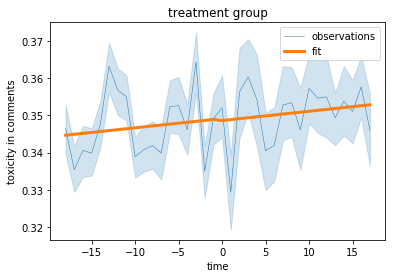

In [12]:
#filter out comments with toxicity score == -1.0 since they were not scored by API
toxicity_data = toxicity_comments_data[toxicity_comments_data.toxicity >= 0]
toxicity_data = toxicity_data[toxicity_data.body != "[removed]"]

toxicity_data['post_treatment'] = toxicity_data['created_utc'] > quarDataUnix
toxicity_data['time'] = toxicity_data['created_utc'].apply(getTimeChunkIndex)

model = smf.ols('toxicity ~ time + post_treatment',data = toxicity_data)
results = model.fit()

print(results.summary2())

# fitted values
# data['fit'] = np.exp(results.fittedvalues)
toxicity_data['fit'] = results.fittedvalues

ax = sns.lineplot(data=toxicity_data,x='time',y='toxicity',linewidth=0.5)
ax = sns.lineplot(data=toxicity_data,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('toxicity in comments');

                  Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.002   
Dependent Variable:  toxicity          AIC:                 471.3610
Date:                2019-08-01 18:38  BIC:                 493.2337
No. Observations:    10839             Log-Likelihood:      -232.68 
Df Model:            2                 F-statistic:         9.988   
Df Residuals:        10836             Prob (F-statistic):  4.64e-05
R-squared:           0.002             Scale:               0.061135
--------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
--------------------------------------------------------------------
Intercept              0.2238   0.0052 42.8112 0.0000  0.2136 0.2340
post_treatment[T.True] 0.0001   0.0098  0.0145 0.9884 -0.0191 0.0194
time                   0.0011   0.0005  2.3483 0.0189  0.0002 0.0020
-----------------------------------------------------

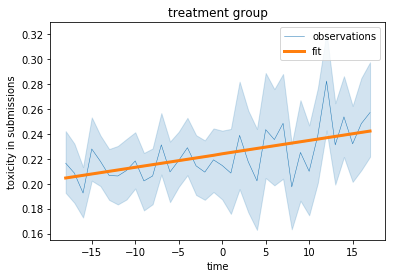

In [13]:
# run toxicity score analysis for submissions
#filter out comments with toxicity score == -1.0 since they were not scored by API
toxicity_data = toxicity_submissions_data[toxicity_submissions_data.toxicity >= 0]
toxicity_data = toxicity_data[toxicity_data.title != "[removed]"]

toxicity_data['post_treatment'] = toxicity_data['created_utc'] > quarDataUnix
toxicity_data['time'] = toxicity_data['created_utc'].apply(getTimeChunkIndex)

model = smf.ols('toxicity ~ time + post_treatment',data = toxicity_data)
results = model.fit()

print(results.summary2())

# fitted values
# data['fit'] = np.exp(results.fittedvalues)
toxicity_data['fit'] = results.fittedvalues

ax = sns.lineplot(data=toxicity_data,x='time',y='toxicity',linewidth=0.5)
ax = sns.lineplot(data=toxicity_data,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('toxicity in submissions');

# Result 4: There was no significant change in toxicity levels (of comments and posts) within r/TRP that was caused by the quarantine.